# Синтаксис: зависимостный парсинг (*dependency parsing*)

Зависимостный парсинг $-$ одна из немногих задач, где лингвистика и компьютерные науки продуктивно взаимодействуют. Основную теорию тут разрабатывают лингвисты, они же размечают корпусы, а модели построены на самых последних разработках в области машинного обучения.

**Что такое парсинг вообще и в какой момент его нужно использовать?**

Сначала мы токенизируем текст и лемматизируем (делаем морфологический разбор), а потом мы переходим к **синтаксису** и вот тут-то нам и нужен парсер.

Самые популярные парсеры:
    
- [**SyntaxNet (DRAGNN)**](https://github.com/tensorflow/models/tree/f2f25096d3dc6561a855dab914cf2913100728d6/research/syntaxnet) от гугла.<br>SyntaxNet активно развивается, но его достаточно трудоемко ставить.
- **UDPipe** от Карлова Университета в Чехии.<br>UDPipe работает похуже, но установить его легче.
- [**Spacy**](https://spacy.io/)
- **TurkuNLP** - от университета Турку (это Финляндия).<br>Позиционируется он как парсер для финского, но там есть много других предобученных моделей и можно обучать свои.
- [**MaltParser**](http://www.maltparser.org/)

При парсинге используется **грамматика зависимостей**, а не грамматика составляющих. Так, любое предложение можно представить в виде дерева зависимостей.

![](https://upload.wikimedia.org/wikipedia/commons/0/0d/Wearetryingtounderstandthedifference_%282%29.jpg)

## SpaCy

+ Библиотека для продвинутого NLP
+ Ряд языков: английский, русский, китайский, немецкий, французский, итальянский, польский, испанский и др. Разрабатываются модели для всё новых языков
+ Про spaCy: https://spacy.io/usage
+ Установка:
```python
pip install -U spacy
```
    - для английского:
    ```python
    python -m spacy download en_core_web_sm
    ```
    - для русского:
    ```python
    python -m spacy download ru_core_news_sm
    ```

In [ ]:
# !pip install -U spacy --q
# !python -m spacy download en_core_web_sm --q
# !python -m spacy download ru_core_news_sm --q

In [ ]:
import spacy

### Функционал

#### Лемматизация (+ токенизация): `.lemma_`

In [ ]:
nlp_en = spacy.load("en_core_web_sm")

In [ ]:
chomsky_doc = nlp_en("Colorless green ideas sleep furiously")
shakespeare_doc = nlp_en("To be, or not to be, that is the question: Whether 'tis nobler in the mind to suffer")

In [ ]:
for token in chomsky_doc:
    print(token.text, token.lemma_)

Colorless colorless
green green
ideas idea
sleep sleep
furiously furiously


In [ ]:
for token in shakespeare_doc:
    print(token.text, token.lemma_)

To to
be be
, ,
or or
not not
to to
be be
, ,
that that
is be
the the
question question
: :
Whether whether
' '
tis tis
nobler nobler
in in
the the
mind mind
to to
suffer suffer


#### Частеречная разметка: `.pos_`

[Документация](https://spacy.io/usage/linguistic-features)

In [ ]:
for token in chomsky_doc:
    print(token.text, token.pos_)

Colorless ADJ
green ADJ
ideas NOUN
sleep VERB
furiously ADV


#### Морфологический анализ: `.morph`

In [ ]:
for token in chomsky_doc:
    print(token.text, token.pos_, token.morph)

Colorless ADJ Degree=Pos
green ADJ Degree=Pos
ideas NOUN Number=Plur
sleep VERB Tense=Pres|VerbForm=Fin
furiously ADV 


#### Синтаксис: деревья зависимостей

In [ ]:
for token in chomsky_doc:
    print(token.text, token.lemma_, token.pos_, token.dep_)

Colorless colorless ADJ amod
green green ADJ amod
ideas idea NOUN nsubj
sleep sleep VERB ROOT
furiously furiously ADV advmod


#### Навигация по дереву: вершины и зависимые

Используется терминология `.head` (вершина) и `.children` (зависимые)

In [ ]:
for token in chomsky_doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

Colorless amod ideas NOUN []
green amod ideas NOUN []
ideas nsubj sleep VERB [Colorless, green]
sleep ROOT sleep VERB [ideas, furiously]
furiously advmod sleep VERB []


In [ ]:
donkey_doc = nlp_en("If a farmer owns a donkey, he beats it.")

In [ ]:
for token in donkey_doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

If mark owns VERB []
a det farmer NOUN []
farmer nsubj owns VERB [a]
owns advcl beats VERB [If, farmer, donkey]
a det donkey NOUN []
donkey dobj owns VERB [a]
, punct beats VERB []
he nsubj beats VERB []
beats ROOT beats VERB [owns, ,, he, it, .]
it dobj beats VERB []
. punct beats VERB []


Найдём детей *beats* справа (`.rights`) и слева (`.lefts`) в дереве:

In [ ]:
donkey_doc = nlp_en("If a farmer owns a donkey, he beats it.")
print(donkey_doc[8])
print(f'{donkey_doc[8].n_lefts} left child(ren): {[token.text for token in donkey_doc[8].lefts]}')
print(f'{donkey_doc[8].n_rights} right child(ren): {[token.text for token in donkey_doc[8].rights]}')

beats
3 left child(ren): ['owns', ',', 'he']
2 right child(ren): ['it', '.']


Теперь найдём тип зависимости, детей слева, детей справа, родителей:

In [ ]:
root = [token for token in donkey_doc if token.head == token][0]  # находим корневой элемент
subject = list(root.lefts)[0]  # берем только детей слева (ака if-часть)
for descendant in subject.subtree:
    assert subject is descendant or subject.is_ancestor(descendant)
    print(descendant.text,  # слово
          descendant.dep_,  # тип зависимости
          descendant.n_lefts,  # сколько детей слева
          descendant.n_rights,  # сколько детей справа
          [ancestor.text for ancestor in descendant.ancestors]  # список родителей
          )

If mark 0 0 ['owns', 'beats']
a det 0 0 ['farmer', 'owns', 'beats']
farmer nsubj 1 0 ['owns', 'beats']
owns advcl 2 1 ['beats']
a det 0 0 ['donkey', 'owns', 'beats']
donkey dobj 1 0 ['owns', 'beats']


Распечатаем часть речи, тип зависимости, вершину:

In [ ]:
for token in donkey_doc:
    print(token.text, token.pos_, token.dep_, token.head.text)

If SCONJ mark owns
a DET det farmer
farmer NOUN nsubj owns
owns VERB advcl beats
a DET det donkey
donkey NOUN dobj owns
, PUNCT punct beats
he PRON nsubj beats
beats VERB ROOT beats
it PRON dobj beats
. PUNCT punct beats


Визуализируем дерево:

In [ ]:
from spacy import displacy

In [ ]:
displacy.render(donkey_doc, style='dep')

#### Named Entity Recognition (NER)

In [ ]:
from spacy.tokens import Span

In [ ]:
doc_twit = nlp_en("President Donald Trump is permanently blocked on Twitter.")

for ent in doc_twit.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Donald Trump 10 22 PERSON
Twitter 49 56 PRODUCT


In [ ]:
ents = [(e.text, e.start_char, e.end_char, e.label_) for e in doc_twit.ents]
print('Before', ents)
# the model didn't recognise "President" :(

president_ent = Span(doc_twit, 0, 1, label="PE")  # create a Span for the new entity, PE = political entity
doc_twit.ents = list(doc_twit.ents) + [president_ent]

ents = [(e.text, e.start_char, e.end_char, e.label_) for e in doc_twit.ents]
print('After', ents)

Before [('Donald Trump', 10, 22, 'PERSON'), ('Twitter', 49, 56, 'PRODUCT')]
After [('President', 0, 9, 'PE'), ('Donald Trump', 10, 22, 'PERSON'), ('Twitter', 49, 56, 'PRODUCT')]


In [ ]:
displacy.render(doc_twit, style='ent')

#### Как обстоят дела с другими языками?

Загрузим модель для русского языка:

In [ ]:
nlp_ru = spacy.load("ru_core_news_sm")

In [ ]:
pancakes_doc = nlp_ru("Блины бабушка очень уж вкусные печет.")
for token in pancakes_doc:
    print(token.text, token.lemma_, token.pos_, token.morph)

Блины блин NOUN Animacy=Inan|Case=Nom|Gender=Masc|Number=Plur
бабушка бабушка NOUN Animacy=Anim|Case=Nom|Gender=Fem|Number=Sing
очень очень ADV Degree=Pos
уж уж PART 
вкусные вкусный ADJ Case=Nom|Degree=Pos|Number=Plur
печет печет NOUN Animacy=Inan|Case=Nom|Gender=Masc|Number=Sing
. . PUNCT 


In [ ]:
displacy.render(pancakes_doc, style='dep')

In [ ]:
mouse_doc = nlp_ru("Какой прекрасный пень!")

displacy.render(mouse_doc, style='dep')

In [ ]:
sem_synt_doc = nlp_ru("Семантику я люблю, а вот синтаксис не очень.")

displacy.render(sem_synt_doc, style='dep')

In [ ]:
kate_doc = nlp_ru("Легендарный Бока и его внук популярный певец Жока пишут код на Python.")

displacy.render(kate_doc, style='ent')

## Universal Dependencies Parser

[Один из туториалов-сравнений](https://habr.com/ru/company/sberbank/blog/418701/)

[**Universal Dependencies**](https://universaldependencies.org/) $-$ это проект по унификации разметки синтаксических корпусов (трибанков) в рамках грамматики зависимостей.

В русском языке количество типов синтаксических связей ограничено: подлежащее, сказуемое и т.д. В английском то же самое, но набор уже другой. Например, там появляется артикль, который тоже надо как-то маркировать. Если бы мы хотели написать волшебный парсер, который мог бы обрабатывать все языки, то довольно быстро уперлись бы в проблемы сопоставления разных грамматик. Героическим создателям Universal Dependencies удалось договориться между собой и разметить все корпусы, которые имелись в их распоряжении, в едином формате.

Для того, чтобы разметить что-то новое, нужно обучить модель на размеченном корпусе. Таких корпусов для русского языка есть несколько (можно посмотреть на сайте Universal Dependencies). Основные и самые большие размеченные корпуса:
+ Syntagrus
+ Taiga

### UDPipe 2.0, принцип работы

+ Сначала текст разделяется на предложения, а предложения $-$ на слова.
+ Затем начинает работу теггер $-$ штука, которая предсказывает морфологические свойства токена: в каком падеже слово стоит, в каком числе. По последним четырем символам каждого слова теггер генерирует гипотезы относительно части речи и морфологических тегов этого слова, а затем при помощи перцептрона отбирает лучший вариант.
+ В UDPipe есть еще лемматизатор, который подбирает для слов начальную форму.
+ потом происходит синтаксический парсинг

В итоге получается какой-то такой разбор по грамматике зависимостей предложения:

Пример для английского            |  Пример для русского
:--------------------------------:|:-------------------------:
![](https://habrastorage.org/getpro/habr/post_images/686/c78/066/686c780661b296250d53cba054317a18.png)  |  ![](https://github.com/hse-ling-python/seminars/blob/master/UDPipe/koshka.png?raw=1)





## UDPipe в Python

+ Установка:
```python
pip install ufal.udpipe
pip install conllu
```
+ вспомогательный скрипт `model.py`: cкачайте его себе с нашего [гитхаба](https://raw.githubusercontent.com/hse-ling-python/seminars/refs/heads/master/UDPipe/model.py).

+ модель для русского (либо *taiga*, либо *syntagrus*): скачать [отсюда](https://github.com/jwijffels/udpipe.models.ud.2.4/tree/master/inst/udpipe-ud-2.4-190531). .

In [ ]:
# !pip install ufal.udpipe --q
# !pip install conllu --q

In [ ]:
!wget -q https://raw.githubusercontent.com/hse-ling-python/seminars/refs/heads/master/UDPipe/model.py
!wget -q https://github.com/jwijffels/udpipe.models.ud.2.4/raw/refs/heads/master/inst/udpipe-ud-2.4-190531/russian-taiga-ud-2.4-190531.udpipe

In [ ]:
import ufal.udpipe
from model import Model
import conllu
from nltk.parse import DependencyGraph

import warnings
import os
from collections import defaultdict, Counter

import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline


warnings.filterwarnings('ignore')

In [ ]:
our_model = Model('russian-taiga-ud-2.4-190531.udpipe')

In [ ]:
def get_conllu(my_model, text):
    sentences = my_model.tokenize(text)

    for sent in sentences:
        my_model.tag(sent)
        my_model.parse(sent)

    conllu_text = my_model.write(sentences, "conllu")
    return conllu_text

#### Парсинг: `get_conllu` вернёт табличку с анализом каждого слова

In [ ]:
parsed_text = get_conllu(our_model, 'Я была в школе целый день. И завтра тоже там буду.')
print(parsed_text)

# newdoc
# newpar
# sent_id = 1
# text = Я была в школе целый день.
1	Я	я	PRON	_	Case=Nom|Number=Sing|Person=1	6	nsubj	_	_
2	была	быть	AUX	_	Aspect=Imp|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|Voice=Act	6	cop	_	_
3	в	в	ADP	_	_	4	case	_	_
4	школе	школя	NOUN	_	Animacy=Inan|Case=Loc|Gender=Masc|Number=Sing	6	nmod	_	_
5	целый	целый	ADJ	_	Animacy=Inan|Case=Acc|Degree=Pos|Gender=Masc|Number=Sing	6	amod	_	_
6	день	день	NOUN	_	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	0	root	_	SpaceAfter=No
7	.	.	PUNCT	_	_	6	punct	_	_

# sent_id = 2
# text = И завтра тоже там буду.
1	И	и	CCONJ	_	_	4	cc	_	_
2	завтра	завтра	ADV	_	Degree=Pos	4	advmod	_	_
3	тоже	тоже	PART	_	_	4	advmod	_	_
4	там	там	ADV	_	Degree=Pos	0	root	_	_
5	буду	быть	AUX	_	Aspect=Imp|Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin|Voice=Act	4	cop	_	SpaceAfter=No
6	.	.	PUNCT	_	_	4	punct	_	SpaceAfter=No




In [ ]:
conllu.parse_tree(parsed_text)

[TokenTree<token={id=6, form=день}, children=[...]>,
 TokenTree<token={id=4, form=там}, children=[...]>]

Получается, что это список из объектов, по одному для каждого предложения. Каждое предложение представляет собой дерево.

In [ ]:
first_tree = conllu.parse_tree(parsed_text)[0]

In [ ]:
first_tree.print_tree()  # вот это на винде не работает, запускайте в Google Colab

(deprel:root) form:день lemma:день upos:NOUN [6]
    (deprel:nsubj) form:Я lemma:я upos:PRON [1]
    (deprel:cop) form:была lemma:быть upos:AUX [2]
    (deprel:nmod) form:школе lemma:школя upos:NOUN [4]
        (deprel:case) form:в lemma:в upos:ADP [3]
    (deprel:amod) form:целый lemma:целый upos:ADJ [5]
    (deprel:punct) form:. lemma:. upos:PUNCT [7]


Разобранные предложения хранятся в формате CONLL:
- слово на каждой строчке,
- тэги через табы,
- предложения отделены двойными отступами.

CONLL $-$ по названию конференции Conference on Computational Natural Language Learning, в рамках который проводились и проводятся соревнования по парсингу.


### Визуализация: `DependencyGraph`

DependencyGraph работает с форматом CONLL, поэтому напишем функцию, которая добавит в наш разбор табы и двойные отступы `get_dep_tree`.

In [ ]:
def get_dep_tree(text):
    trees = []
    for sent in text.split('\n\n'):
        tree = [line for line in sent.split('\n') if line and line[0] != '#']
        trees.append('\n'.join(tree))
    return trees

In [ ]:
conll_parsed_text = get_dep_tree(parsed_text)
conll_parsed_text

['1\tЯ\tя\tPRON\t_\tCase=Nom|Number=Sing|Person=1\t6\tnsubj\t_\t_\n2\tбыла\tбыть\tAUX\t_\tAspect=Imp|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|Voice=Act\t6\tcop\t_\t_\n3\tв\tв\tADP\t_\t_\t4\tcase\t_\t_\n4\tшколе\tшколя\tNOUN\t_\tAnimacy=Inan|Case=Loc|Gender=Masc|Number=Sing\t6\tnmod\t_\t_\n5\tцелый\tцелый\tADJ\t_\tAnimacy=Inan|Case=Acc|Degree=Pos|Gender=Masc|Number=Sing\t6\tamod\t_\t_\n6\tдень\tдень\tNOUN\t_\tAnimacy=Inan|Case=Acc|Gender=Masc|Number=Sing\t0\troot\t_\tSpaceAfter=No\n7\t.\t.\tPUNCT\t_\t_\t6\tpunct\t_\t_',
 '1\tИ\tи\tCCONJ\t_\t_\t4\tcc\t_\t_\n2\tзавтра\tзавтра\tADV\t_\tDegree=Pos\t4\tadvmod\t_\t_\n3\tтоже\tтоже\tPART\t_\t_\t4\tadvmod\t_\t_\n4\tтам\tтам\tADV\t_\tDegree=Pos\t0\troot\t_\t_\n5\tбуду\tбыть\tAUX\t_\tAspect=Imp|Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin|Voice=Act\t4\tcop\t_\tSpaceAfter=No\n6\t.\t.\tPUNCT\t_\t_\t4\tpunct\t_\tSpaceAfter=No',
 '']

Нарисуем:


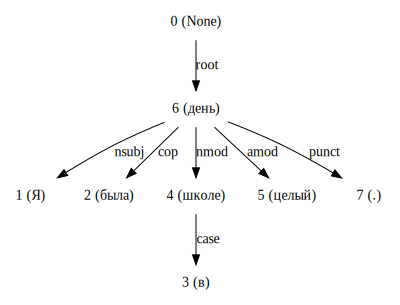

In [ ]:
graph_first_tree = DependencyGraph(conll_parsed_text[0])
graph_first_tree

Какая-то фигня получилась. Но это и выше было видно.


#### Узлы графа: `triples`.

In [ ]:
graph_first_tree.root = graph_first_tree.nodes[0]  # чтобы метод сработал нужно установить корневой элемент
# при этом, если в разборе ошибка и вы счтаете, что root - это graph_first_tree.nodes[2],
# использовать этот корень в .triples не получится, будет ошибка
graph_first_tree.nodes[2]

{'address': 2,
 'word': 'была',
 'lemma': 'быть',
 'ctag': 'AUX',
 'tag': '_',
 'feats': 'Aspect=Imp|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|Voice=Act',
 'head': 6,
 'deps': defaultdict(list, {}),
 'rel': 'cop'}

In [ ]:
list(graph_first_tree.triples())

[((None, 'TOP'), 'root', ('день', 'NOUN')),
 (('день', 'NOUN'), 'nsubj', ('Я', 'PRON')),
 (('день', 'NOUN'), 'cop', ('была', 'AUX')),
 (('день', 'NOUN'), 'nmod', ('школе', 'NOUN')),
 (('школе', 'NOUN'), 'case', ('в', 'ADP')),
 (('день', 'NOUN'), 'amod', ('целый', 'ADJ')),
 (('день', 'NOUN'), 'punct', ('.', 'PUNCT'))]

### Задачи

1. **Достать из корпуса все возможные модификаторы какого-нибудь слова**

In [ ]:
modifiers = Counter()
for tree in trees:
    d = DependencyGraph(tree)
    d.root = d.nodes[0]
    triples = list(d.triples())

    for e1, rel, e2 in triples:
        if e1[0] == 'писатель' and rel == 'amod':
            modifiers[e2[0]] += 1

In [ ]:
modifiers

Counter({'церковный': 1,
         'Замечательный': 1,
         'разоблаченный': 1,
         'известный': 1,
         'великий': 2,
         'Сам': 1,
         'умеющий': 1,
         'наш': 1,
         'любимый': 1,
         'древнегреческий': 1,
         'русский': 1,
         'изощренный': 1,
         'Британский': 1,
         'московский': 2,
         'грузинский': 2,
         'оказавшийся': 1})

2. **Анализ текстов с помощью зависимостей**

Запомним, что теперь у нас есть способ доставать все узлы, и попробуем проанализировать тексты с помощью зависимостей. Сами парсить не будет, а возьмем уже готовые разборы из Тайги.

Возьмем маленький кусочек (Arzamas). Cкачать его можно тут: https://linghub.ru/static/Taiga/Arzamas.zip

В нем есть папка с обработанными текстами. Соберем их в один список. Нашим конечным заданием будет достать все модификаторы для какого-нибудь конкретного слова в этом корпусе.

In [ ]:
# !wget -q https://linghub.ru/static/Taiga/Arzamas.zip
# !unzip -q Arzamas.zip

In [ ]:
path = 'Arzamas/texts_tagged/'
files = [path + file for file in os.listdir(path)]

Посмотрим, что вообще лежит в этих файлах:

In [ ]:
with open(files[2]) as file:
    text_file = file.read()

Тут снова формат CONLL очевидно. Давайте еще раз на него внимательно посмотрим. У нас есть тут какая-то метаинформация через #, теги через таб, деревья для отдельных предложений.

In [ ]:
tree = [x for x in text_file.split('\n\n')[0].split('\n')]
tree[:10]

['# text = # newpar',
 '# sent_id = 13160',
 '# text = В начале XX века благодаря стремительному развитию строительных технологий возникли новые принципы архитектурного проектирования.',
 '1\tВ\tв\tADP\t_\t_\t2\tcase\t_\t_',
 '2\tначале\tначало\tNOUN\t_\tAnimacy=Inan|Case=Loc|Gender=Neut|Number=Sing\t10\tobl\t_\t_',
 '3\tXX\txx\tNUM\t_\t_\t4\tnummod\t_\t_',
 '4\tвека\tвек\tNOUN\t_\tAnimacy=Inan|Case=Gen|Gender=Masc|Number=Sing\t2\tnmod\t_\t_',
 '5\tблагодаря\tблагодаря\tADP\t_\t_\t7\tcase\t_\t_',
 '6\tстремительному\tстремительный\tADJ\t_\tCase=Dat|Degree=Pos|Gender=Neut|Number=Sing\t7\tamod\t_\t_',
 '7\tразвитию\tразвитие\tNOUN\t_\tAnimacy=Inan|Case=Dat|Gender=Neut|Number=Sing\t10\tobl\t_\t_']

Соберем все деревья (то есть все предложения) из всех файлов в один список. Так мы сможем работать с этими данными как с корпусом текстов.

In [ ]:
trees = []

for file in files:
    with open(file) as text_f:
        parsed_sents = text_f.read().split('\n\n')

    for sent in parsed_sents:
        # уберем мета информацию
        tree = [line for line in sent.split('\n') if line[0] != '#']
        trees.append('\n'.join(tree))

Рандомное дерево из получившившегося списка:

In [ ]:
trees[80]

'1\tНа\tна\tADP\t_\t_\t3\tcase\t_\t_\n2\tсвинцовой\tсвинцовой\tADJ\t_\tCase=Loc|Degree=Pos|Gender=Fem|Number=Sing\t3\tamod\t_\t_\n3\tтабличке\tтабличка\tNOUN\t_\tAnimacy=Inan|Case=Loc|Gender=Fem|Number=Sing\t8\tobl\t_\t_\n4\tпосле\tпосле\tADP\t_\t_\t7\tcase\t_\t_\n5\tразных\tразный\tADJ\t_\tCase=Gen|Degree=Pos|Number=Plur\t7\tamod\t_\t_\n6\tмагических\tмагический\tADJ\t_\tCase=Gen|Degree=Pos|Number=Plur\t7\tamod\t_\t_\n7\tслов\tслово\tNOUN\t_\tAnimacy=Inan|Case=Gen|Gender=Neut|Number=Plur\t8\tobl\t_\t_\n8\tидет\tидти\tVERB\t_\tAspect=Imp|Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act\t0\troot\t_\t_\n9\tдлинный\tдлинный\tADJ\t_\tCase=Nom|Degree=Pos|Gender=Masc|Number=Sing\t10\tamod\t_\t_\n10\tсписок\tсписок\tNOUN\t_\tAnimacy=Inan|Case=Nom|Gender=Masc|Number=Sing\t8\tnsubj\t_\t_\n11\tлошадиных\tлошадиный\tADJ\t_\tCase=Gen|Degree=Pos|Number=Plur\t12\tamod\t_\t_\n12\tкличек\tкличка\tNOUN\t_\tAnimacy=Inan|Case=Gen|Gender=Fem|Number=Plur\t10\tnmod\t_\t_\n13\t(\t(\tPUNCT\t_\t

Пора нарисовать красивый граф для какого-нибудь предложения из этого корпуса.

Поскольку это данные, на которых можно обучать модели, они хорошо размечены и тут уже в корне дерева у нас нормальный предикат и разбор получается хороший.

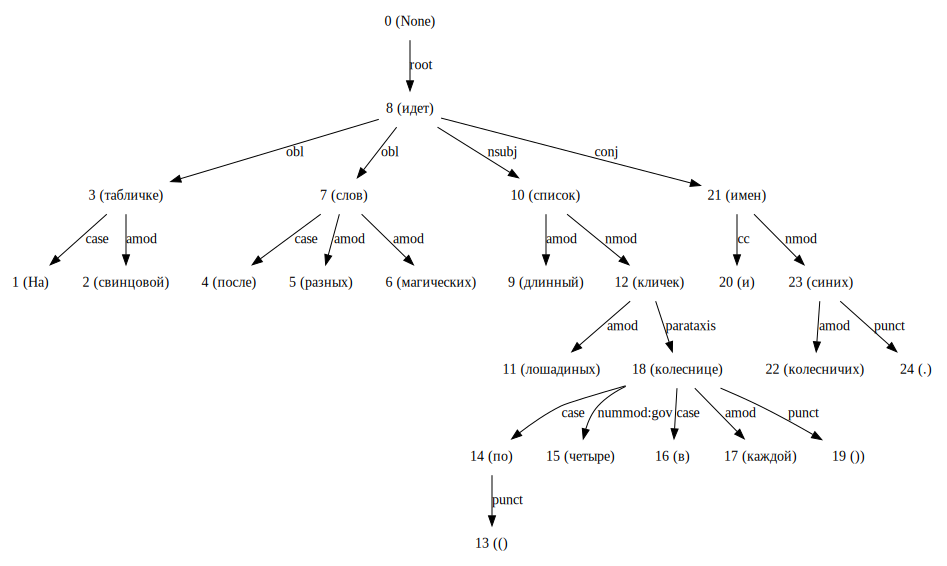

In [ ]:
graph_tree_80 = DependencyGraph(trees[80])
graph_tree_80

Или так:

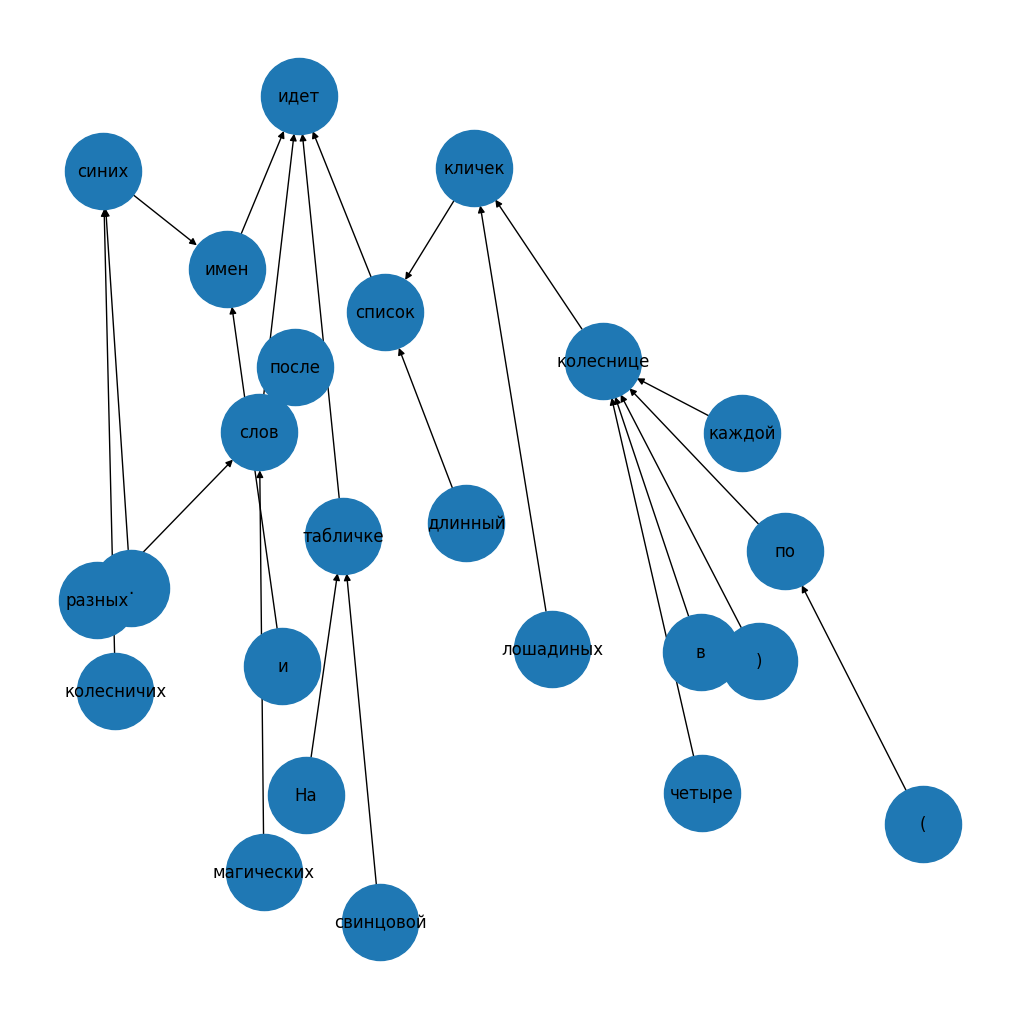

In [ ]:
plt.figure(figsize=(10,10))
nx.draw(graph_tree_80.nx_graph(), labels=graph_tree_80.nx_labels, node_size=3000)

Вспомним наш прекрасный метод доставания узлов:

In [ ]:
graph_tree_80.root = graph_tree_80.nodes[0]  # чтобы метод сработал нужно установить корневой элемент
list(graph_tree_80.triples())

[((None, 'TOP'), 'root', ('идет', 'VERB')),
 (('идет', 'VERB'), 'obl', ('табличке', 'NOUN')),
 (('табличке', 'NOUN'), 'case', ('На', 'ADP')),
 (('табличке', 'NOUN'), 'amod', ('свинцовой', 'ADJ')),
 (('идет', 'VERB'), 'obl', ('слов', 'NOUN')),
 (('слов', 'NOUN'), 'case', ('после', 'ADP')),
 (('слов', 'NOUN'), 'amod', ('разных', 'ADJ')),
 (('слов', 'NOUN'), 'amod', ('магических', 'ADJ')),
 (('идет', 'VERB'), 'nsubj', ('список', 'NOUN')),
 (('список', 'NOUN'), 'amod', ('длинный', 'ADJ')),
 (('список', 'NOUN'), 'nmod', ('кличек', 'NOUN')),
 (('кличек', 'NOUN'), 'amod', ('лошадиных', 'ADJ')),
 (('кличек', 'NOUN'), 'parataxis', ('колеснице', 'NOUN')),
 (('колеснице', 'NOUN'), 'case', ('по', 'ADP')),
 (('по', 'ADP'), 'punct', ('(', 'PUNCT')),
 (('колеснице', 'NOUN'), 'nummod:gov', ('четыре', 'NUM')),
 (('колеснице', 'NOUN'), 'case', ('в', 'ADP')),
 (('колеснице', 'NOUN'), 'amod', ('каждой', 'ADJ')),
 (('колеснице', 'NOUN'), 'punct', (')', 'PUNCT')),
 (('идет', 'VERB'), 'conj', ('имен', 'NOUN'

Какие вообще отношения в Universal Dependencies маркируются для русского языка?

https://universaldependencies.org/ru/index.html

**Какие еще вопросы можно решать с помощью UDPipe?**

+ Достать какую-нибудь составляющую. Например, достать из всех предложений вашего корпуса именные группы.
+ Достать самые короткие пути (пути по графу зависимостей), соединяющие между собой какие-нибудь фразы.
+ Искать предложения или конструкции, похожие между собой по структуре.
+ и т.д.

**Задание**:


1. Дадим SpaCy на разбор предложение с синтаксической неоднозначностью. Какой анализ предлагает SpaCy?
    + *John saw the man on the mountain with a telescope.*
    + *I'm glad I'm a man, and so is Lola.*
    + больше примеров: https://en.wikipedia.org/wiki/Syntactic_ambiguity

2. Дадим примеры на острова (приведены ниже с традиционной оценкой их приемлемости). Какой анализ предлагает SpaCy?
    - *What<sub>i</sub> does Sarah believe that Susan thinks that John bought \_<sub>i</sub>?*
    + Complex NPs
      - _<sup>\*</sup>Who<sub>i</sub> did Mary see the report that was about _<sub>i</sub>?_<br>(cf. *Mary saw the report that was about the senator.*)
      - _<sup>?*</sup>Which sportscar<sub>i</sub> did the color of _<sub>i</sub> delight the baseball player?_<br>(cf. *The color of the sportscar delighted the baseball player.*)

    + Complements of manner-of-speaking verbs
       - _<sup>??</sup>What<sub>i</sub> did Mary whisper that Bill liked _<sub>i</sub>?_<br>(cf. *Mary whispered that Bill liked wine.*)

    + Complex NPs (both noun complements and relative clauses)
        - _<sup>*</sup>The senator who<sub>i</sub> Mary saw the report that was about _<sub>i</sub> bothered many people on the committee._

    + Subject islands
        - _<sup>?*</sup>The sportscar which<sub>i</sub> the color of _<sub>i</sub> delighted the baseball player…_

    + Complements of manner-of-speaking verbs
        - _<sup>?</sup>The wine which<sub>i</sub> Mary whispered that Bill liked _<sub>i</sub> was a Cabernet._

3. Справляется ли SpaCy с эллипсисом:
    + *John can [play the guitar]<sub>i</sub>, and Mary can _<sub>i</sub>, too.*
4. Достанем все именные группы для слов с тегом `nsubj` при помощи UDPipe, т.е. достанем все именные группы в именительном падеже

